# Урок 7. Сверточные нейронные сети для анализа текста

#### Берем отызывы за лето (из архива с материалами или предыдущего занятия)

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk import word_tokenize

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [2]:
df = pd.read_excel('отзывы за лето.xls', usecols=['Rating', 'Content'])

In [3]:
df['Rating'] = df['Rating'] - 1

In [4]:
df.head(3)

,Rating,Content
0,4,It just works!
1,3,В целом удобноное приложение...из минусов хотя...
2,4,Отлично все


In [5]:
stopwords = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [6]:
def preprocess_text(text):
    txt = str(text)
    txt = ''.join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in stopwords]
    return " ".join(txt)

In [7]:
df['Content'] = df['Content'].apply(preprocess_text)

In [8]:
# считаем количество уникальных слов в отзыве (максимум, в среднем)
df['Content'].apply(lambda x: len(np.unique(str(x).split(' ')))).max(),\
df['Content'].apply(lambda x: len(np.unique(str(x).split(' ')))).mean()


(94, 4.8396824628491215)

In [9]:
max_words = 300
max_len = 40
num_classes = 5

In [10]:
train_corpus = ' '.join(df['Content'])

In [11]:
tokens =  word_tokenize(train_corpus)

In [12]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [13]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [14]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [15]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

### 1. Учим conv сеть для классификации


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
import tensorflow as tf

In [45]:
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPool1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
#from tensorflow.keras.objectives import categorical_crossentropy
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import utils

In [46]:
from tensorflow.keras.layers import BatchNormalization

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], test_size=0.25, random_state=1, shuffle=True)

In [20]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [21]:
y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_test = utils.to_categorical(y_test, num_classes=num_classes)

In [22]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(Conv1D(64, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
batch_size = 256
epochs = 15

In [25]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
61/61 [==============================] - 1s 10ms/step - loss: 1.2198 - accuracy: 0.6876 - val_loss: 0.9088 - val_accuracy: 0.7131
Epoch 2/15
61/61 [==============================] - 0s 6ms/step - loss: 0.7707 - accuracy: 0.7460 - val_loss: 0.6908 - val_accuracy: 0.7642
Epoch 3/15
61/61 [==============================] - 0s 6ms/step - loss: 0.6776 - accuracy: 0.7673 - val_loss: 0.6679 - val_accuracy: 0.7698
Epoch 4/15
61/61 [==============================] - 0s 6ms/step - loss: 0.6565 - accuracy: 0.7722 - val_loss: 0.6595 - val_accuracy: 0.7713
Epoch 5/15
61/61 [==============================] - 0s 6ms/step - loss: 0.6451 - accuracy: 0.7777 - val_loss: 0.6550 - val_accuracy: 0.7733
Epoch 6/15
61/61 [==============================] - 0s 6ms/step - loss: 0.6336 - accuracy: 0.7813 - val_loss: 0.6550 - val_accuracy: 0.7733
Epoch 7/15
61/61 [==============================] - 0s 6ms/step - loss: 0.6236 - accuracy: 0.7829 - val_loss: 0.6481 - val_accuracy: 0.7737
Epoch 8/15
61/61 [=

In [26]:
import matplotlib.pyplot as plt

In [27]:
def draw_report(history):
    fig, ax = plt.subplots(1,2, figsize=(14, 4))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].legend()

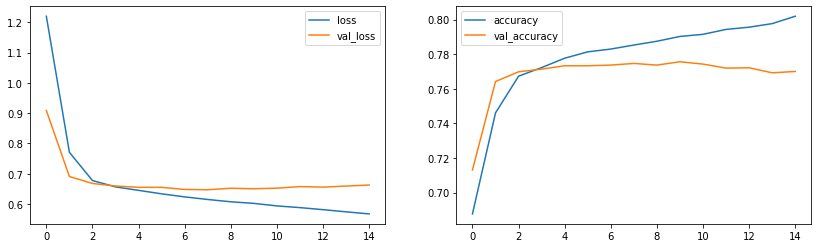

In [28]:
draw_report(history)

### 2. Берём предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?

In [29]:
from gensim.models import KeyedVectors
ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")

C:\Users\Pavel\Anaconda3\envs\tensorflow\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], test_size=0.25, random_state=1, shuffle=True)

In [31]:
y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_test = utils.to_categorical(y_test, num_classes=num_classes)

In [32]:
maxlen = 50

In [33]:
def text_to_sequence_w2v(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in ru_emb:
            result.append(ru_emb[word])
    padding = [[0]*300]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [34]:
X_train = np.asarray([text_to_sequence_w2v(text, max_len) for text in X_train])
X_test = np.asarray([text_to_sequence_w2v(text, max_len) for text in X_test])

In [35]:
X_train.shape

(15494, 40, 300)

In [36]:
model = Sequential()
model.add(Conv1D(64, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
61/61 [==============================] - 2s 26ms/step - loss: 1.2321 - accuracy: 0.6771 - val_loss: 0.8990 - val_accuracy: 0.7380
Epoch 2/15
61/61 [==============================] - 1s 17ms/step - loss: 0.8006 - accuracy: 0.7515 - val_loss: 0.7582 - val_accuracy: 0.7531
Epoch 3/15
61/61 [==============================] - 1s 16ms/step - loss: 0.7174 - accuracy: 0.7618 - val_loss: 0.7164 - val_accuracy: 0.7564
Epoch 4/15
61/61 [==============================] - 1s 15ms/step - loss: 0.6732 - accuracy: 0.7709 - val_loss: 0.6931 - val_accuracy: 0.7593
Epoch 5/15
61/61 [==============================] - 1s 14ms/step - loss: 0.6439 - accuracy: 0.7766 - val_loss: 0.6792 - val_accuracy: 0.7590
Epoch 6/15
61/61 [==============================] - 1s 15ms/step - loss: 0.6217 - accuracy: 0.7839 - val_loss: 0.6713 - val_accuracy: 0.7626
Epoch 7/15
61/61 [==============================] - 1s 15ms/step - loss: 0.6027 - accuracy: 0.7902 - val_loss: 0.6695 - val_accuracy: 0.7642
Epoch 8/15
61

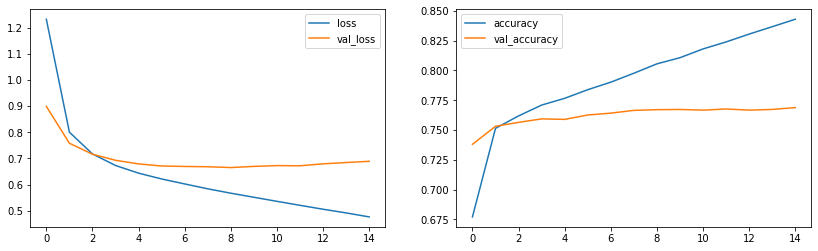

In [38]:
draw_report(history)

### 3. Сравнить разные виды эмбедингов tf.Embeddings word2vec/Fasttext (в качестве агригации попробовать разные виды не только среднее для документа)

Вот здесь немного запутался. Мы на уроке мы делали агрегации (средние и с учетом idf), потом складывали w2v эмбединги, и получали матрицу [m, n], где m-количество предложений, а n - наш вектор, описывающий предложение. Приводили мы текст к такому виду, чтобы отправить эту матрицу в классификатор. <br>
В случае с эмбедингами и нейросетями, в разрезе темы урока (свертки), нам не нужно ничего агрегировать, мы отправляем в сеть тензон (m, n, k), где m - кол-во отзывов, n - слова в предложнии, а k - это эмбединги слов, по которым и работает Conv1d. <br>
Понимаю зачем нужна агрегация для обычного классификатора, но для свертки не очень понятно что и зачем агрегировать <br> По сути мы заменили слой <b> model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len)) </b> из первой модели, предобработав сам датасет эмбедингами из word 2 vec

### 4. По моделировать различные архитектуры сетей (несколько слоёв свёрток с пулингом без с полносвязанными и без них) по смотреть какая архитектура быстрее переобучается, какая более хорошо решает текущую задачу

In [39]:
model = Sequential()
model.add(Conv1D(124, 3, padding='same'))
model.add(Activation("relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(64, 3,  padding='same'))
model.add(Activation("relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(20))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

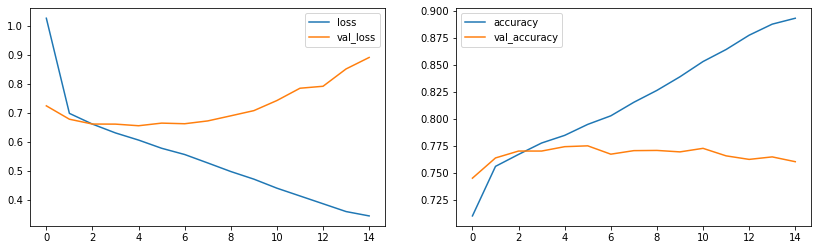

In [41]:
draw_report(history)

In [42]:
batch_size = 32

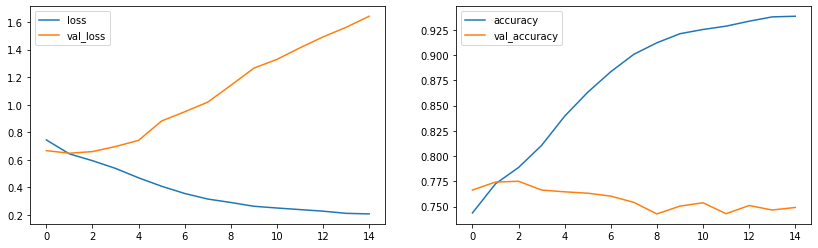

In [43]:
model = Sequential()
model.add(Conv1D(124, 3, padding='same'))
model.add(Activation("relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(80))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
draw_report(history)

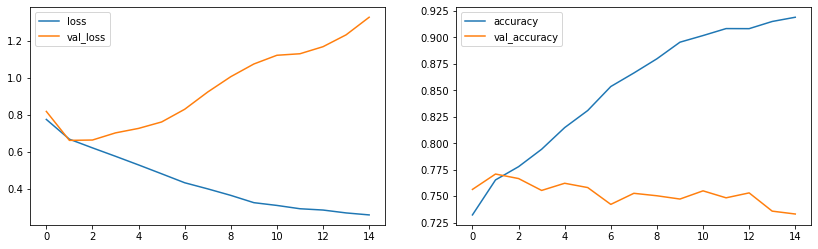

In [48]:
model = Sequential()
model.add(Conv1D(124, 3, padding='same'))
model.add(Activation("relu"))
model.add(MaxPool1D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(80))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(20))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
draw_report(history)

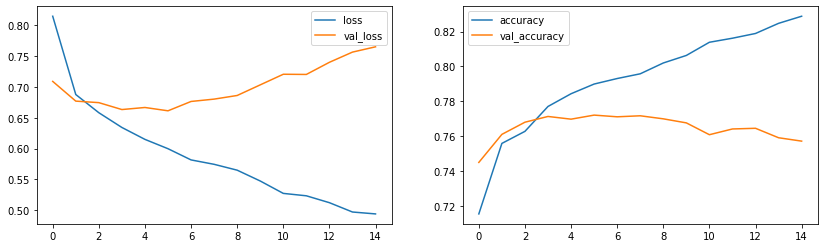

In [52]:
model = Sequential()
model.add(Conv1D(32, 2, padding='same'))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
draw_report(history)

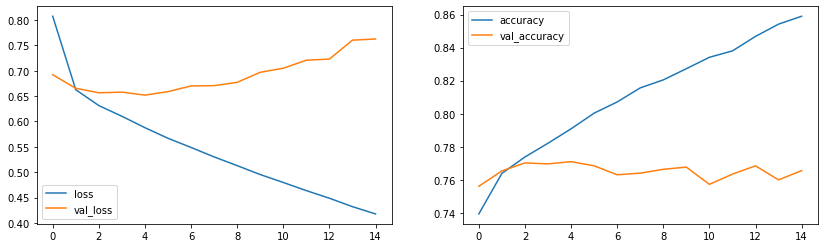

In [56]:
model = Sequential()
model.add(Conv1D(32, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(6))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
draw_report(history)

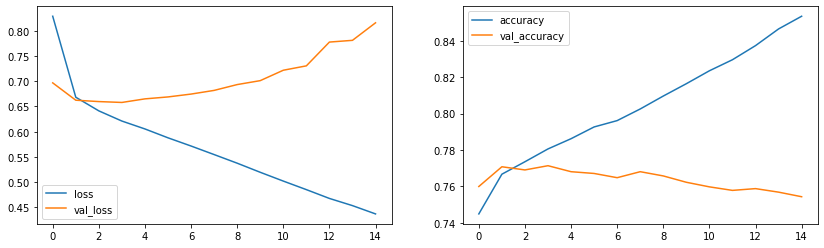

In [57]:
model = Sequential()
model.add(Conv1D(64, 3))
model.add(Conv1D(32, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(6))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
draw_report(history)